In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
from google.colab.patches import cv2_imshow as sh
from skimage import measure, color, io

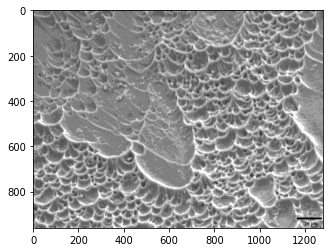

In [15]:
img = cv2.imread('/content/drive/MyDrive/BTP/Results- Part-1/dataset/images/image1.png', 0)
plt.imshow(img, cmap='gray')
lab = cv2.imread('/content/drive/MyDrive/BTP/Results- Part-1/dataset/mask-duplicate/label11.png', cv2.IMREAD_COLOR)
img[(lab != [255, 0, 0])[:, : ,0]] = 255

In [23]:
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]


# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "hed_model/deploy.prototxt.txt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)


# load the input image and grab its dimensions, for future use while defining the blob
#img = cv2.imread("pebbles.jpg")
plt.imshow(img)
(H, W) = img.shape[:2]

# construct a blob out of the input image 
#blob is basically preprocessed image. 
#OpenCV’s new deep neural network (dnn ) module contains two functions that 
#can be used for preprocessing images and preparing them for 
#classification via pre-trained deep learning models.
# It includes scaling and mean subtraction
#How to calculate the mean?
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             mean=(105, 117, 123),
                             swapRB= False, crop=False)

#View image after preprocessing (blob)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
plt.imshow(blob_for_plot)


# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

plt.imshow(hed, cmap='gray')
img = hed

error: ignored

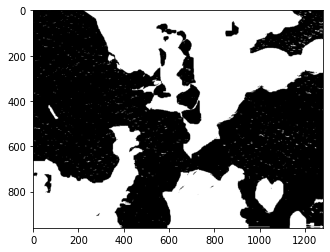

In [ ]:
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

In [ ]:
kernel = np.ones((1, 1), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=50)
opening = (np.logical_not(opening)).astype(np.uint8)

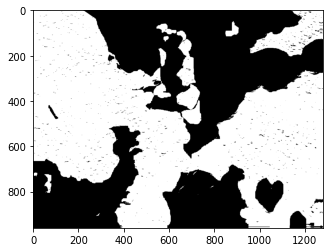

In [ ]:
plt.imshow(opening, cmap='gray')

In [ ]:

sure_bg = cv2.dilate(opening, kernel, iterations=50)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
ret2, sure_fg = cv2.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)
unknown = cv2.subtract(sure_bg, sure_fg)

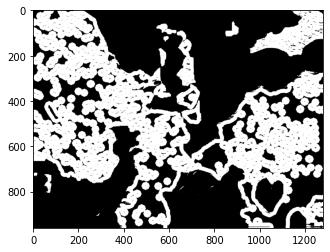

In [ ]:
plt.imshow(unknown, cmap='gray')

In [ ]:
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers+10
markers = np.uint8(markers)
markers[unknown==1] = 0

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(img, np.int32(markers))
img2 = color.label2rgb(markers, bg_label=10)

<Figure size 432x576 with 0 Axes>

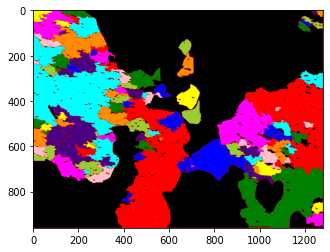

<Figure size 432x576 with 0 Axes>

In [ ]:
plt.imshow(img2)
plt.figure(figsize=(6, 8))

In [ ]:
skeleton_img = np.zeros(img.shape, dtype=np.uint8)
skeleton_img[markers == -1] = [255, 255, 255]

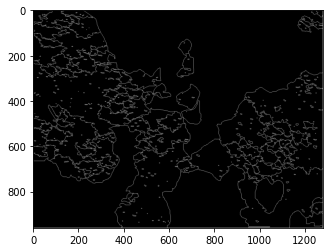

<Figure size 432x576 with 0 Axes>

In [ ]:
plt.imshow(skeleton_img)
plt.figure(figsize=(6, 8))
plt.show()

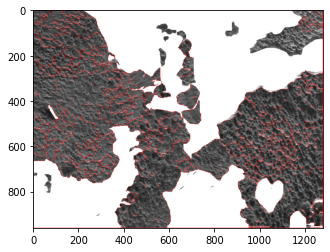

<Figure size 432x576 with 0 Axes>

In [ ]:
img[markers == -1] = [255, 0, 0]
plt.imshow(img)
plt.figure(figsize=(6, 8))
plt.show()

In [ ]:
props = measure.regionprops_table(markers, intensity_image=img, properties=['area', 'equivalent_diameter', 'mean_intensity', 'orientation', 'perimeter', 'max_intensity' ,'min_intensity', 'major_axis_length', 'minor_axis_length'])

import pandas as pd
df = pd.DataFrame(props)
print(df)

       area  equivalent_diameter  mean_intensity-0  mean_intensity-1  \
0    578430           858.184100        240.528283        240.528283   
1      2705            58.686565         76.519039         76.519039   
2      6140            88.417706         78.501303         78.501303   
3      2684            58.458318         79.104694         79.104694   
4       322            20.248040         81.950311         81.950311   
..      ...                  ...               ...               ...   
128      97            11.113246        115.597938        115.597938   
129     659            28.966616         65.339909         65.339909   
130     853            32.955627         64.466589         64.466589   
131    1849            48.520304         59.977285         59.977285   
132    3106            62.886263         57.234385         57.234385   

     mean_intensity-2  orientation     perimeter  max_intensity-0  \
0          240.528283    -0.793802  20745.521564              255 

In [ ]:
df.to_excel('/content/drive/MyDrive/BTP/Result- Part-2/Dimples_Statistics/image1.xls', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.
